模型：

自变量:
1. 价差:是最新的行情价减去过去一段时间内的平均价格
 - 衡量最新价格与平均价格的偏离程度
2. 申买申卖量:申买量减去申卖量
 - 根据市场微观结构,申买量大于申卖量的时候,价格会明显上升
3. 价格相对波动率:最近一段时间内的价格的波动率和远期一段时间内的价格波动率之比
 - **相关论文(SSRN-id3301545)**表示,短期内过大的波动会造成反转行情,而温和的价格波动则更倾向于形成趋势行情

因变量:
- 平均收益率

回归算法:
- 采用ridge回归,防止过拟合

In [1]:
import numpy as np

import pandas as pd

import pymysql as psq

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import datetime

from sklearn import linear_model

from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split

figsize=(40,10)

# con = psq.connect("localhost","root","root","rb_quote")
# SQL = """
# select * from rb_quote.rb_quote_sign where ins_id = 'rb1905'
# """
# # 1905是主力合约,数据量比较大
# df = pd.read_sql(SQL,con)

In [2]:
pd.options.display.max_columns = 30
pd.options.display.max_rows= 100

In [3]:
df = pd.read_csv("rb1905.csv")
df.date_time = pd.to_datetime(df.date_time)
df.set_index(['date_time'],inplace=True)

In [4]:
df

,ins_id,newest_price,last_price,yesterday_close,yesterday_holding,today_open,highest_price,lowest_price,trading_volume,trading_amount,holding,today_close,this_price,upper_price,volume,buy_p1,buy_v1,sell_p1,sell_v1,today_avg_price
date_time,,,,,,,,,,,,,,,,,,,,
2018-10-08 08:59:00,rb1905,3712.0,3711.0,3719.0,406100,3712.0,3712.0,3712.0,442,1.640704e+07,406340,0.0,0.0,4044.0,442,3712.0,1,3719.0,10,37120.0000
2018-10-08 09:00:00,rb1905,3717.0,3711.0,3719.0,406100,3712.0,3720.0,3712.0,682,2.533124e+07,406518,0.0,0.0,4044.0,682,3715.0,2,3719.0,1,37142.5806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-28 15:00:00,rb1905,3404.0,3422.0,3396.0,2496928,3387.0,3420.0,3382.0,2915936,9.916103e+10,2374342,3404.0,3400.0,3661.0,2915936,3403.0,2,3404.0,598,34006.5857
2018-12-28 15:16:31,rb1905,3404.0,3422.0,3396.0,2496928,3387.0,3420.0,3382.0,2915936,9.916103e+10,2374342,3404.0,3400.0,3661.0,2915936,3403.0,2,3404.0,598,34006.5857


In [4]:
df_dev = df.copy()

# 准备入模dataframe

In [5]:
# 行情数据选取最新价，申买申卖量作为原始字段
df_model = df_dev[['newest_price','buy_v1','sell_v1']].copy()
# -----------------------------------------------------------------------------------------------------------
# 当前行情数据和moving average价格之差
df_model['Price_Minus_MeanPrice'] = (df_model.newest_price - df_model.newest_price.rolling(50000).mean())
# 筛选出outlier
df_model = df_model[df_model.Price_Minus_MeanPrice.between(df_model.Price_Minus_MeanPrice.quantile(0.01),df_model.Price_Minus_MeanPrice.quantile(0.99))]
# -----------------------------------------------------------------------------------------------------------
# 计算比例波动率，短期内的波动率和长期的波动率之比
day_freq = 50000
days_long = 10
days_short = 5
df_model['scale_vola'] = (df_model.newest_price.pct_change().apply(np.square)\
.rolling(day_freq*days_long).mean()*days_short)\
.apply(np.sqrt)\
/(df_model.newest_price.pct_change().apply(np.square)\
.rolling(day_freq*days_long*2).mean()*days_short)\
.apply(np.sqrt)
# -----------------------------------------------------------------------------------------------------------
# 申买量，申卖量之差的moving average
df_model['Buy_Minus_Sell'] = (df_model.buy_v1 - df_model.sell_v1).rolling(50000).mean()
df_model = df_model[df_model.Buy_Minus_Sell.between(df_model.Buy_Minus_Sell.quantile(0.01),df_model.Buy_Minus_Sell.quantile(0.99))]
# -----------------------------------------------------------------------------------------------------------
# 平均收益率的moving average
df_model['Moving_Avg_Return'] = df_model.newest_price.diff().rolling(50000).mean()*100
# -----------------------------------------------------------------------------------------------------------
# 剔除掉由于做moving average生成的空值
df_model.dropna(inplace=True)

In [6]:
# 选择出自变量和因变量
X = df_model[['Price_Minus_MeanPrice', 'scale_vola', 'Buy_Minus_Sell']]
y = df_model[['Moving_Avg_Return']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [7]:
# 采用Scikit learn的Ridge回归
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

print(ridge.coef_)
print(ridge.intercept_)

[[ 0.00282422  0.00776478 -0.00119032]]
[-0.0127746]


In [8]:
full_predict = ridge.intercept_+\
ridge.coef_[0][0]*df_model['Price_Minus_MeanPrice']+\
ridge.coef_[0][1]*df_model['scale_vola']+\
ridge.coef_[0][2]*df_model['Buy_Minus_Sell']

df_model['Full_Predict'] = full_predict
# 计算出未来收益率的预测值

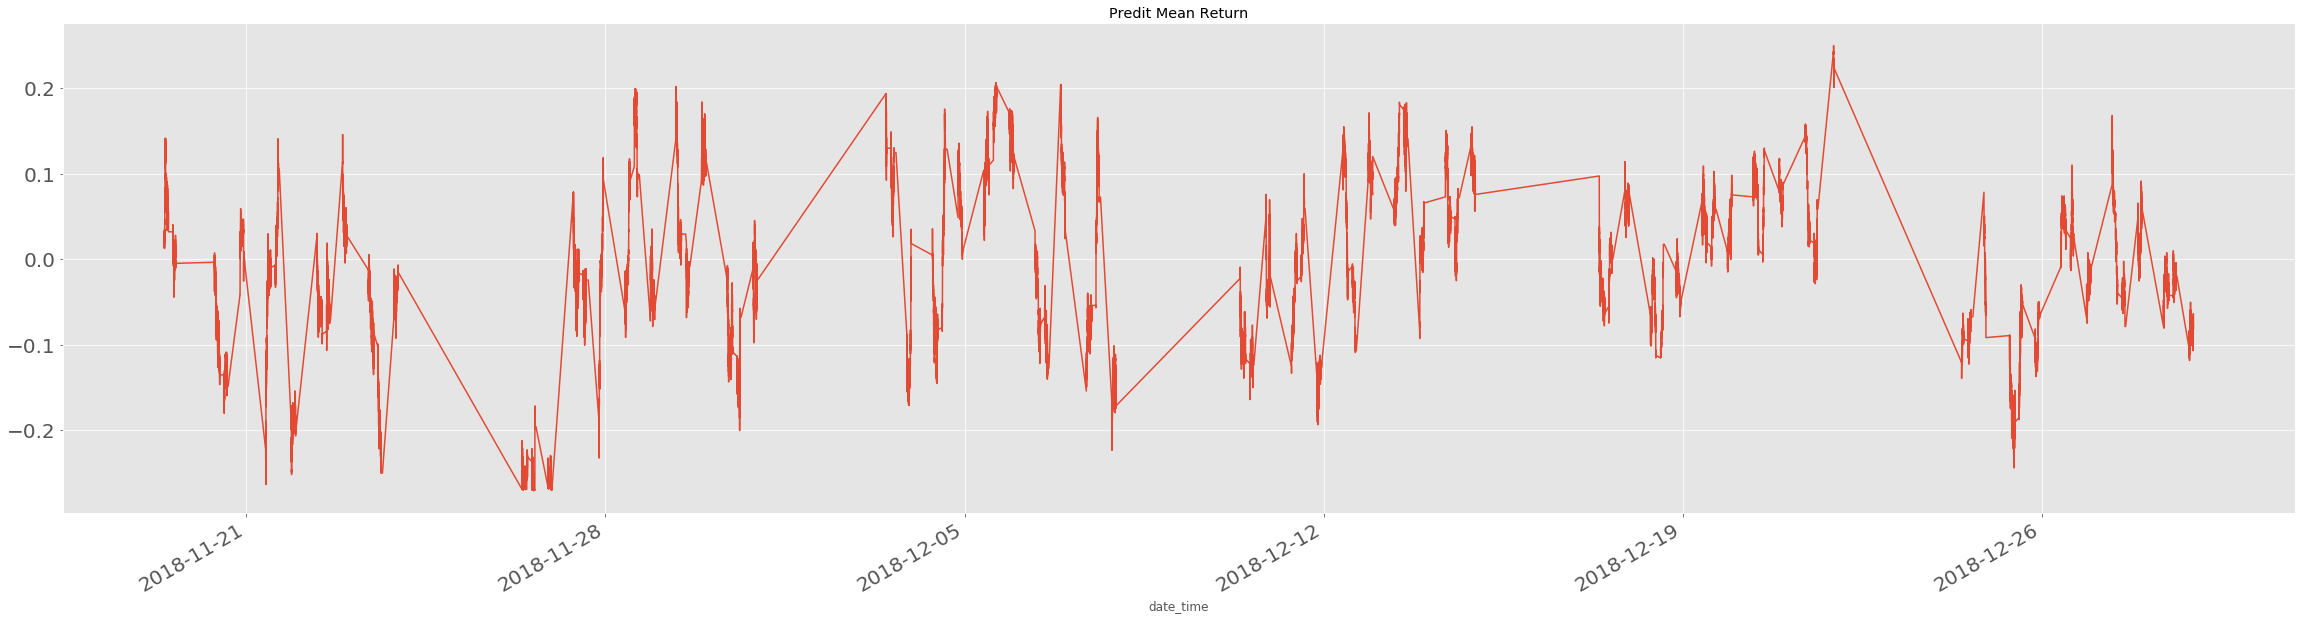

In [103]:
full_predict.plot(figsize=figsize,title='Predit Mean Return',fontsize=20)

# ↑平均收益率的预测值

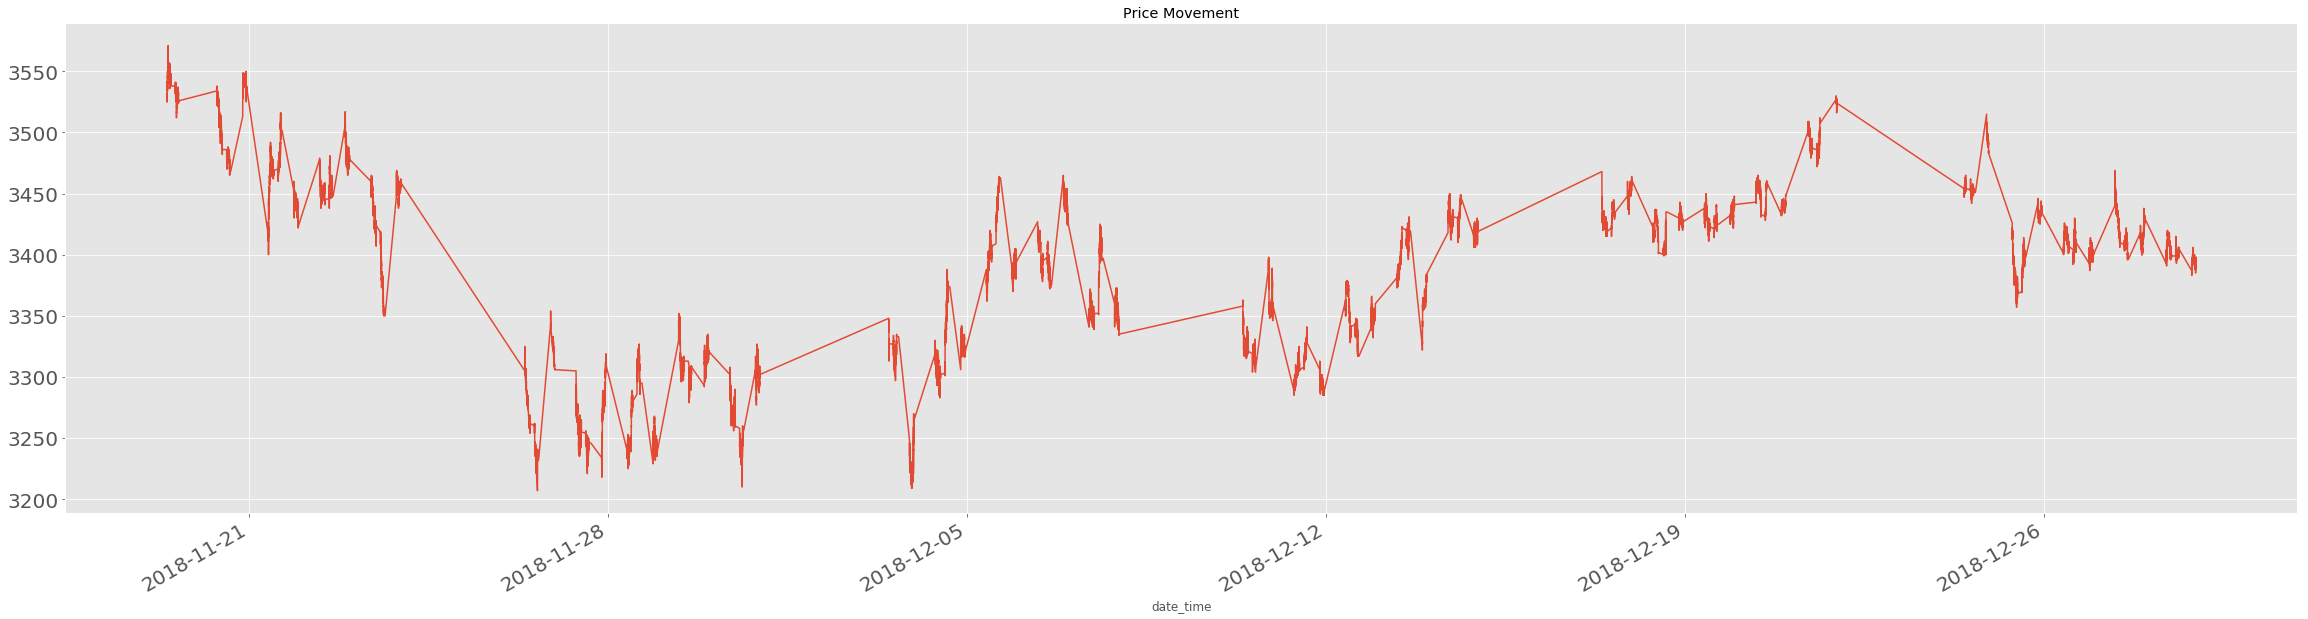

In [104]:
df_model.newest_price.plot(figsize=figsize,title="Price Movement",fontsize=20)

# ↑价格走势

In [98]:
#  设置开仓,平仓的双侧阈值
# -----------------------------------------------------------------------------------------------------------------
df_model['signal'] = df_model.Full_Predict.apply(lambda x : 1 if x > 0.15 and x <0.25 else 0  -1 if x < -0.2 else 0)
# -----------------------------------------------------------------------------------------------------------------

In [93]:
df_model

,newest_price,buy_v1,sell_v1,Price_Minus_MeanPrice,scale_vola,Buy_Minus_Sell,Moving_Avg_Return,Full_Predict,signal
date_time,,,,,,,,,
2018-11-19 09:32:43,3529.0,109,27,6.06282,1.080603,-9.72958,0.004,0.024320,0
2018-11-19 09:32:44,3529.0,95,38,6.06278,1.080600,-9.72816,0.004,0.024318,0
...,...,...,...,...,...,...,...,...,...
2018-12-28 15:00:00,3404.0,2,598,1.38864,0.955920,15.48110,-0.014,-0.019858,0
2018-12-28 15:16:31,3404.0,2,598,1.38878,0.955921,15.46816,-0.014,-0.019842,0


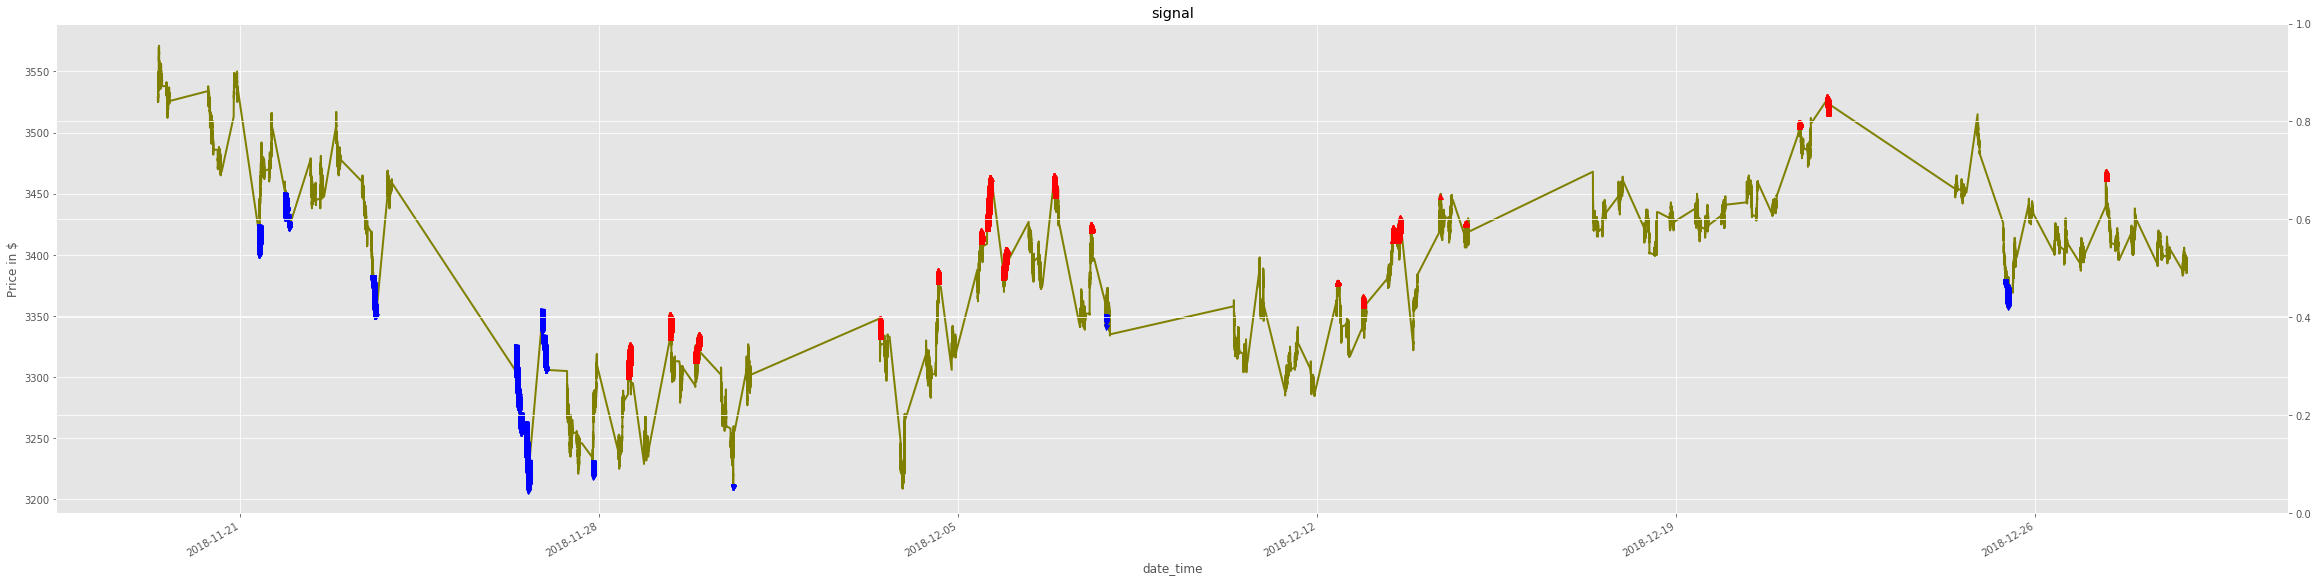

In [109]:
limit = 'signal'
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(111,  ylabel='Price in $')
# ax2 = fig.add_subplot(212,  ylabel='volume')
df_model.newest_price.plot(ax=ax1, color='olive', lw=2.,title=limit)
ax1.plot(df_model[df_model[limit] == 1].index,df_model[df_model[limit] == 1 ]['newest_price'],\
         '^', markersize=5, color='r')
ax1.plot(df_model[df_model[limit] == -1].index,df_model[df_model[limit] == -1 ]['newest_price'],\
         'v', markersize=5, color='b')

ax2 = ax1.twinx()

# df_model['Full_Predict'].plot(ax=ax2, color='aqua', lw=2.,title='Predict',grid=False)


plt.show()

# ↑红色为买入点，蓝色为卖出点

In [11]:
#  设置开仓,平仓的双侧阈值
# -----------------------------------------------------------------------------------------------------------------
df_model['signal'] = df_model.Full_Predict.apply(lambda x : -1 if x > 0.15 and x <0.25 else 1 if x < -0.2 else 0)
# -----------------------------------------------------------------------------------------------------------------

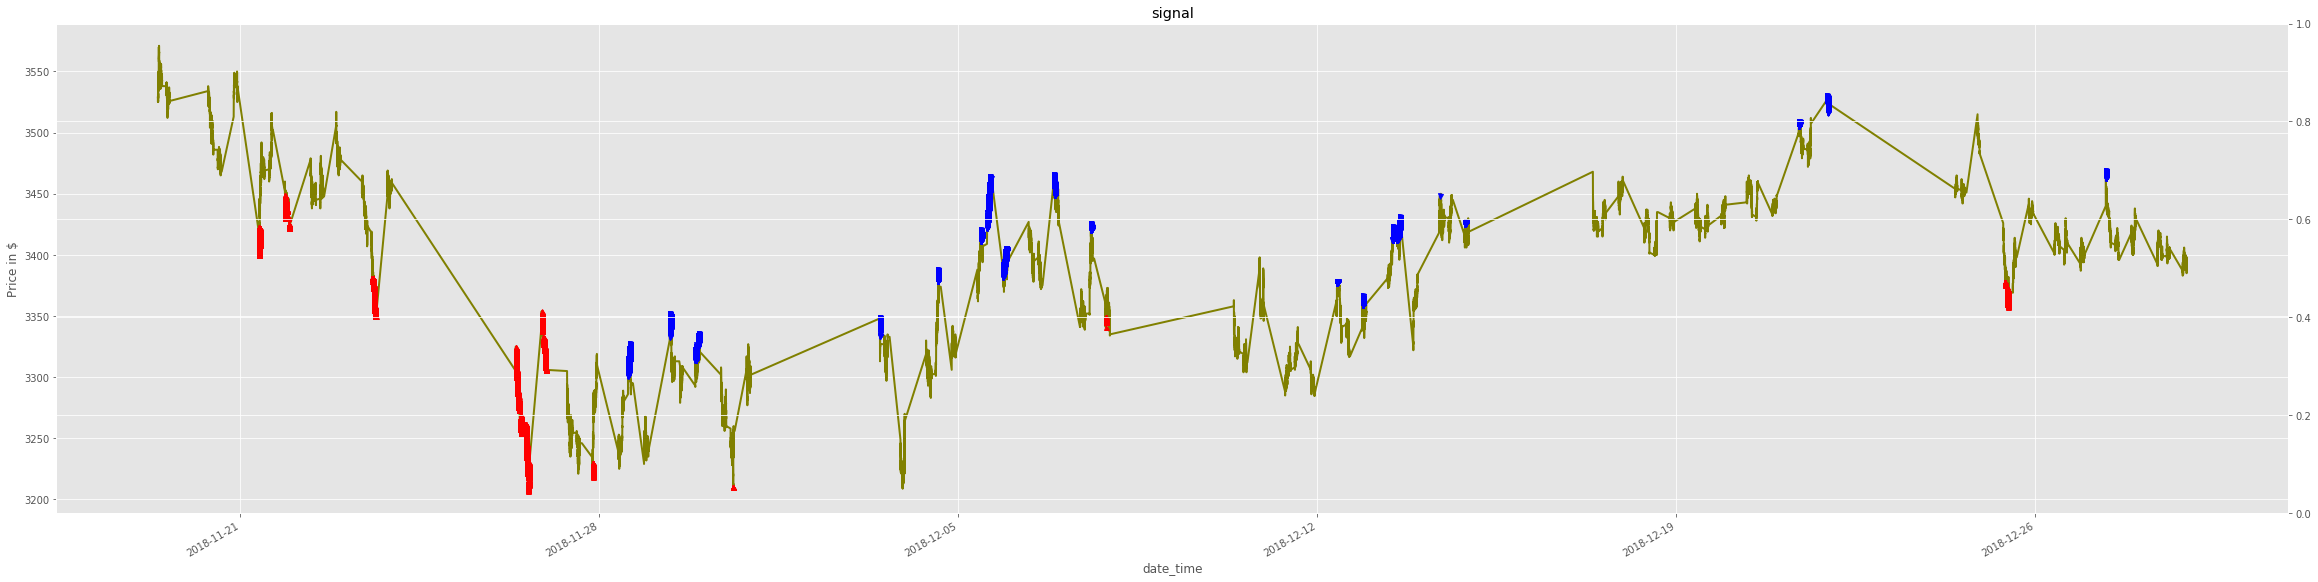

In [12]:
limit = 'signal'
fig = plt.figure(figsize=(40,10))
ax1 = fig.add_subplot(111,  ylabel='Price in $')
# ax2 = fig.add_subplot(212,  ylabel='volume')
df_model.newest_price.plot(ax=ax1, color='olive', lw=2.,title=limit)
ax1.plot(df_model[df_model[limit] == 1].index,df_model[df_model[limit] == 1 ]['newest_price'],\
         '^', markersize=5, color='r')
ax1.plot(df_model[df_model[limit] == -1].index,df_model[df_model[limit] == -1 ]['newest_price'],\
         'v', markersize=5, color='b')

ax2 = ax1.twinx()

# df_model['Full_Predict'].plot(ax=ax2, color='aqua', lw=2.,title='Predict',grid=False)


plt.show()

# ↑当调整一下买入卖出，即可将趋势策略改为震荡策略，红色为卖出点，蓝色为买入点

# --------------------------------------------------------------------------------------------------
# 模型总结
自变量:
1. 价差:是最新的行情价减去过去一段时间内的平均价格
 - 衡量最新价格与平均价格的偏离程度
2. 申买申卖量:申买量减去申卖量
 - 根据市场微观结构,申买量大于申卖量的时候,价格会明显上升
3. 价格相对波动率:最近一段时间内的价格的波动率和远期一段时间内的价格波动率之比
 - 相关论文(SSRN-id3301545)表示,短期内过大的波动会造成反转行情,而温和的价格波动则更倾向于形成趋势行情

因变量:
- 平均收益率

回归算法:
- 采用ridge回归,防止过拟合

思考点:

- 回看期的选择
  - 不同的回看期代表不同的市场周期
  - 在震荡和趋势行情转换的时候，趋势类策略总是会有滞后
  - 是否可以通过计算不同周期的各类指标，判断行情是出于震荡还是处于趋势，可能对算力的要求较高
- 阈值的设定
  - 阈值设定较低则开仓平仓较为频繁，在波动幅度较小，频繁震荡的行情中，容易亏损
  - 阈值设定较低则不容易开仓，但是胜率较高
- 震荡行情的处理方式
  - 停止交易或者清仓，等待行情明朗后再进行
  - 降低回看期的周期，切换到短线操作模式，尽可能灵敏的捕捉到小行情，**但是要考虑到交易成本的限制**
  - 震荡又分为区间震荡和无序震荡，需要进一步学习

不足点:
- 数据量不够丰富
- 时间跨度不够长
- 资金管理(加仓减仓的规则,是靠遍历或者靠统计得出阈值)
  - 在得到预测值的情况下如何优化开仓的条件(避免短期内的极端行情造成的错误的交易信号,尤其是在震荡行情中,很容易造成亏损)
  - 极端行情下，根据过去的历史行情数据，设定相应的分位数作为两端的阈值，避免产生错误的交易信号，因为极端的行情通常不能持续，大涨大跌很容易亏损
- 单一策略稳定性不足
 - 如果能够采用相关性较低的策略组，资金的稳定性将会提升
- tick级别的数据持续输出过多的交易喜好
 - 我暂时没有想到很好的办法来解决这个问题，不过设置一个时间区间应该是一条路